In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices

%matplotlib inline

In [2]:
def get_frequencencies(wave_data, sampling_frequency):
    n = wave_data.shape[0]
    sample_count = (n/sampling_frequency) # estimated samples
    print(sample_count)
    sp = np.fft.fft(wave_data, n, norm = 'ortho')
    freq = np.fft.fftfreq(n, d = 1/sampling_frequency)
    
    frequencies = pd.DataFrame(freq, columns=['Frequency'])
    frequencies['Amplitude'] = np.abs(sp)/sample_count
    frequencies['Phase'] = np.angle(sp)
    frequencies['Real'] = np.real(sp)
    frequencies['Imaginary'] = np.imag(sp)
    frequencies['wave'] = sp
    frequencies = frequencies[frequencies.Amplitude > 0.1*frequencies.Amplitude.max()] # Greater than 10% of the max amplitude
    frequencies.set_index('Frequency', inplace=True)
    return frequencies

In [3]:
def reconstruct_wave(magnitudes, time):
    omega = np.reshape(2*np.pi*magnitudes.index,(magnitudes.shape[0],1))
    time = np.reshape(time,(1, time.shape[0]))
    return (np.cos((omega @ time)).T @ magnitudes)/2#*np.pi#*(n**0.1)) 
    # Scaling factor needed to make the wave have the same amplitude as the original wave

## Working with Waves

In [ ]:
wave = np.genfromtxt('babes/wave.csv', delimiter=',')
estimated_sampling_frequency = 30 #sampling_frequency; changes the anplitude, not the shape of the curve

n = wave.shape[0]
# n = 4
sample_count = (n/estimated_sampling_frequency) # estimated samples

time_arr = np.linspace(start = 0, stop = sample_count, num = wave.shape[0])

plt.plot(wave)

In [ ]:
# sp = np.fft.fft(wave, n, norm = 'ortho')
# freq = np.fft.fftfreq(n, d = 1/estimated_sampling_frequency)

In [ ]:
# frequencies = pd.DataFrame(freq, columns=['Frequency'])
# frequencies['Amplitude'] = np.abs(sp)/sample_count
# frequencies['Phase'] = np.angle(sp)
# frequencies['Real'] = np.real(sp)
# frequencies['Imaginary'] = np.imag(sp)
# frequencies['wave'] = sp
# frequencies = frequencies[frequencies.Amplitude > 0.1*frequencies.Amplitude.max()] # Greater than 10% of the max amplitude
# frequencies.set_index('Frequency', inplace=True)
# frequencies.head()

In [ ]:
# Create a function to get the frequencies of a wave
frequencies = get_frequencencies(wave, estimated_sampling_frequency)
frequencies.head()

### Wave Reconstruction

In [ ]:
reconstructed_wave = reconstruct_wave(frequencies.Amplitude, time_arr)

plt.figure(figsize= (20,5))
plt.plot(reconstructed_wave, label='Reconstructed Wave')
plt.plot(wave, label='Original Wave')
# plt.plot(np.fft.ifft(frequencies['wave'], n, norm = 'ortho'), label='IFFT Wave') # Inacurate in reduced dimensions
plt.legend(loc = 4)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

## FFT Model

### Reading Data

10.0

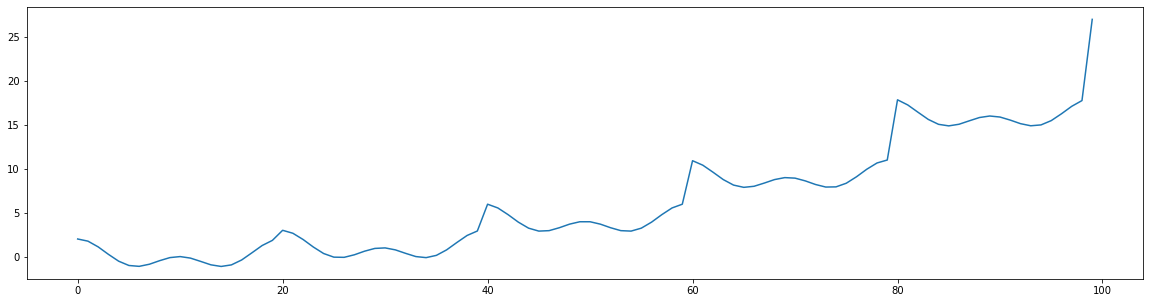

In [478]:
df = pd.read_csv('babes/wave_with_slope3.csv')

estimated_sampling_frequency = 10 #sampling_frequency; changes the anplitude, not the shape of the curve

n = df.shape[0]
# n = 4
sample_count = (n/estimated_sampling_frequency) # estimated samples

time_arr = np.linspace(start = 0, stop = sample_count, num = df.shape[0])

plt.figure(figsize= (20,5))
plt.plot(df)
sample_count

### Breaking Data into Chunks/Seasonal Cycles

In [479]:
estimated_seasons = 5
season_length = n//estimated_seasons

seasons = {}

for i in range(estimated_seasons):
    seasons['season_'+str(i)] = df['0'].iloc[i*season_length :(i+1)*season_length].reset_index(drop=True)

seasons_df = pd.DataFrame(seasons)
seasons_df.reset_index(inplace=True)
seasons_df.head()

,index,season_0,season_1,season_2,season_3,season_4
0,0,2.000000,2.989941,5.959904,10.910297,17.841798
1,1,1.755341,2.652102,5.533479,10.401075,17.256669
2,2,1.102191,1.939693,4.771316,9.599259,16.425746
3,3,0.252989,1.083159,3.918351,8.760554,15.611622
4,4,-0.526756,0.346923,3.233956,8.135408,15.052110


<module 'matplotlib.pyplot' from '/Users/rchaks/opt/anaconda3/envs/aml-proj/lib/python3.9/site-packages/matplotlib/pyplot.py'>

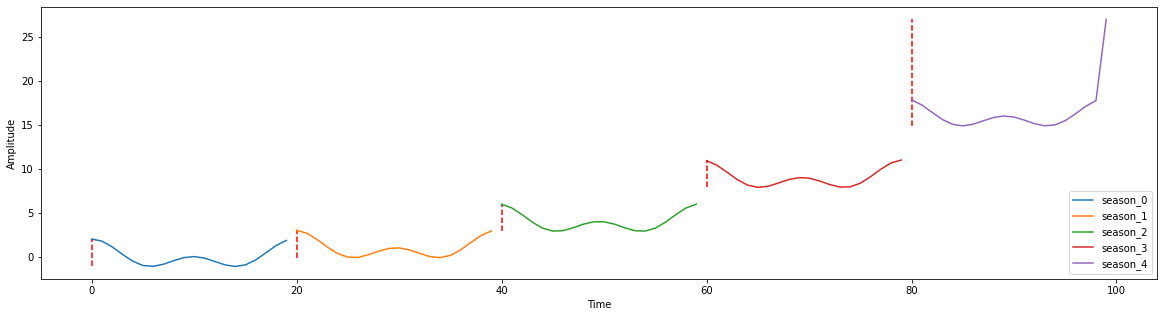

In [480]:
def plot_data(df, title=None):
    plt.figure(figsize= (20,5)) 
    for i, cols in enumerate(df.columns[1:]):
        plt.plot([i*season_length + j for j in range(df.shape[0])], df[cols].values,label=cols)
        plt.vlines(i*season_length, df[cols].min(), df[cols].max(), color='r', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend(loc = 4)
    plt.title(title)
    return plt

plot_data(seasons_df)

### Remove Linear Trends in seasonal cycles

In [481]:
residuals_df = {}

models_dict = {}

for cols in seasons_df.columns[1:]:
    y, X = dmatrices(f'{cols} ~ index', data=seasons_df, return_type='dataframe')
    model = sm.OLS(y, X)       # Set up the model
    result = model.fit()       # Fit model (find the intercept and slopes)
    models_dict[cols] = result
    residuals_df[cols] = result.resid # Residuals
    # print(result.params)

residuals_df = pd.DataFrame(residuals_df)
residuals_df.reset_index(inplace=True)

residuals_df.head()

,index,season_0,season_1,season_2,season_3,season_4
0,0,1.753296,1.855812,1.939700,2.004224,2.820337
1,1,1.532523,1.529975,1.513276,1.482999,2.082751
2,2,0.903257,0.829569,0.751113,0.669181,1.099372
3,3,0.077940,-0.014962,-0.101852,-0.181528,0.132791
4,4,-0.677920,-0.739194,-0.786248,-0.818677,-0.579177


In [482]:
models_dict

{'season_0': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff2f1f1c6a0>,
 'season_1': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff2d1d1cb80>,
 'season_2': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff2d261f130>,
 'season_3': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff2d261fe80>,
 'season_4': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff2d2625c10>}

<module 'matplotlib.pyplot' from '/Users/rchaks/opt/anaconda3/envs/aml-proj/lib/python3.9/site-packages/matplotlib/pyplot.py'>

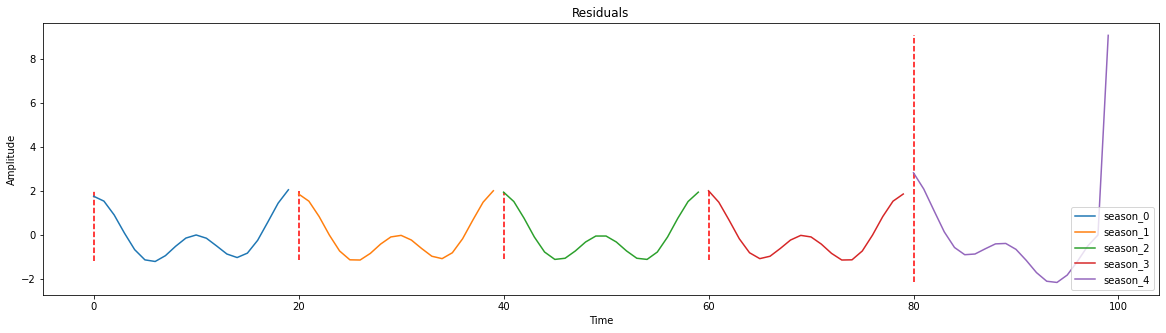

In [483]:
plot_data(residuals_df, title='Residuals')

### Reconstructing the Residual Wave

2.0
2.0
2.0
2.0
2.0
           Amplitude     Phase      Real  Imaginary                wave
Frequency                                                              
 0.5        1.143841  0.180062  2.250697   0.409703  2.250697+0.409703j
 1.0        1.096508  0.139321  2.171766   0.304546  2.171766+0.304546j
-1.0        1.096508 -0.139321  2.171766  -0.304546  2.171766-0.304546j
-0.5        1.143841 -0.180062  2.250697  -0.409703  2.250697-0.409703j


<module 'matplotlib.pyplot' from '/Users/rchaks/opt/anaconda3/envs/aml-proj/lib/python3.9/site-packages/matplotlib/pyplot.py'>

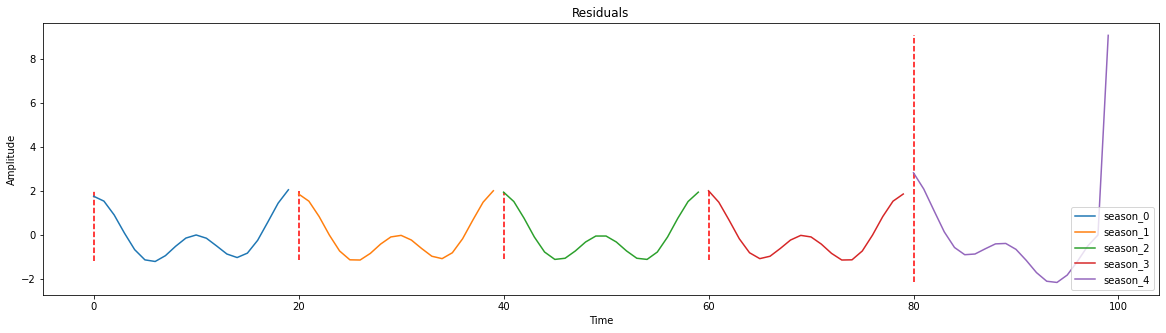

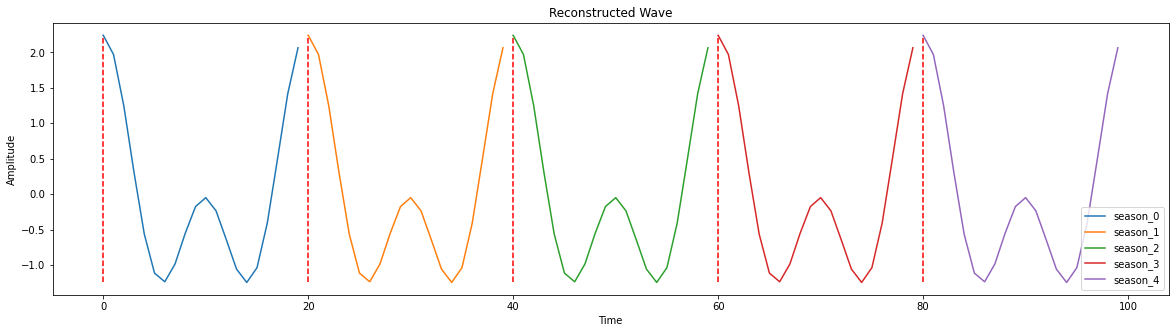

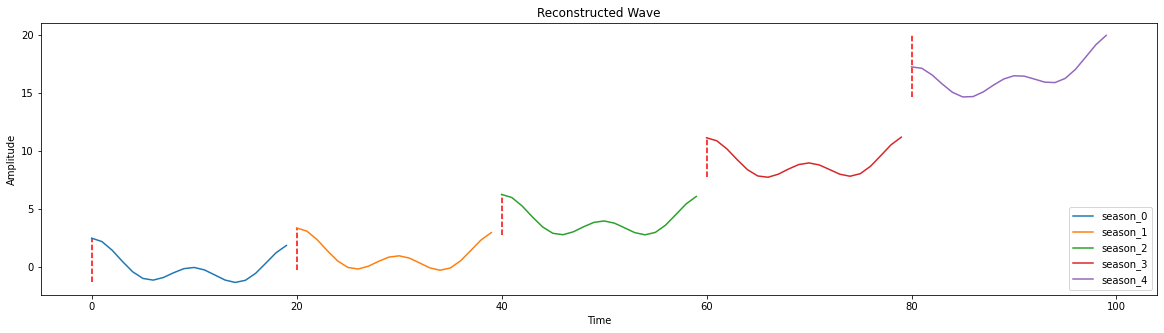

In [487]:
reconstruct = {}
for cols in residuals_df.columns[1:]:
    _ = get_frequencencies(residuals_df.season_0, estimated_sampling_frequency)
    reconstruct[cols] = reconstruct_wave(_.Amplitude, time_arr[:season_length])

reconstruct = pd.DataFrame(reconstruct).reset_index()

print(_)

plot_data(residuals_df, title = "Residuals")
plot_data(reconstruct, title = "Reconstructed Wave")


# Adding Linear trend to the wave
for cols in reconstruct.columns[1:]:
    _ = pd.DataFrame([1]*season_length, columns=['intercept'])
    _['index'] = reconstruct[cols].index.values
    trend = models_dict[cols].predict(_)
    reconstruct[cols] += trend
    
plot_data(reconstruct, title = "Reconstructed Wave")

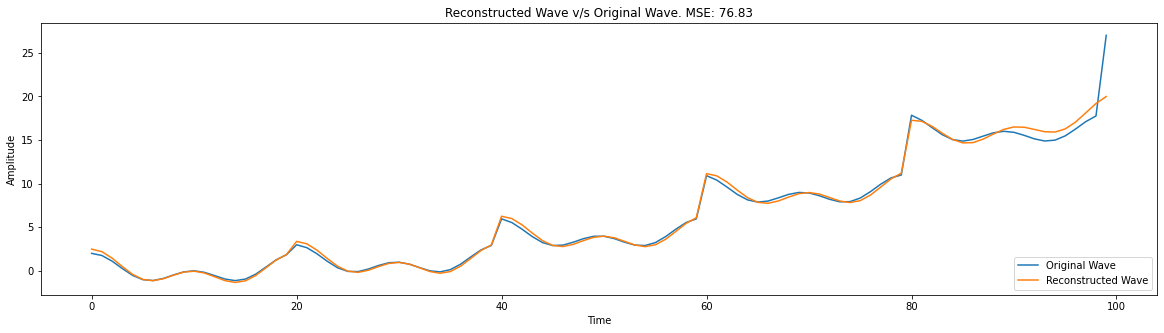

In [488]:
plt.figure(figsize= (20,5))
plt.plot(df.to_numpy(), label='Original Wave')
plt.plot(reconstruct.iloc[:,1:].to_numpy().T.flatten(), label='Reconstructed Wave')
plt.legend(loc = 4)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Reconstructed Wave v/s Original Wave. MSE: '+str(np.round(np.mean((df.to_numpy() - reconstruct.iloc[:,1:].to_numpy().T.flatten())**2),2)))
plt.show()

In [489]:
plt.savefig('plots/reconstructed_wave2.png')

<Figure size 432x288 with 0 Axes>

# Fourier Regression of seasonal cycles

### Reading Data

In [396]:
df = pd.read_csv('babes/wave_with_slope3.csv').rename({'0':'wave'}, axis=1)

estimated_sampling_frequency = 10 #sampling_frequency; changes the anplitude, not the shape of the curve

estimated_seasons = 5

sample_count 10.0


,index,wave
0,0,2.000000
1,1,1.755341
2,2,1.102191
3,3,0.252989
4,4,-0.526756


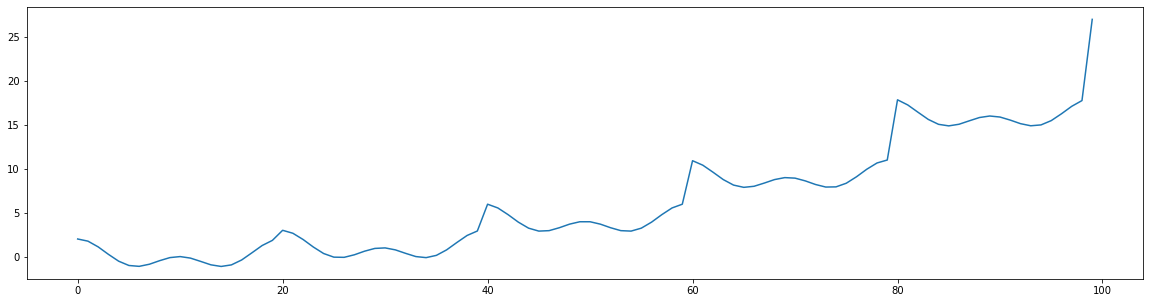

In [397]:
n = df.shape[0]
# n = 4
sample_count = (n/estimated_sampling_frequency) # estimated samples

time_arr = np.linspace(start = 0, stop = sample_count, num = df.shape[0])

plt.figure(figsize= (20,5))
plt.plot(df)
print('sample_count',sample_count)
df = df.reset_index()
df.head()

### Breaking Data into Chunks/Seasonal Cycles

In [398]:
season_length = n//estimated_seasons

seasons = {}

for i in range(estimated_seasons):
    seasons['season_'+str(i)] = df['wave'].iloc[i*season_length :(i+1)*season_length].reset_index(drop=True)

seasons_df = pd.DataFrame(seasons)
seasons_df.reset_index(inplace=True)
seasons_df.head()

,index,season_0,season_1,season_2,season_3,season_4
0,0,2.000000,2.989941,5.959904,10.910297,17.841798
1,1,1.755341,2.652102,5.533479,10.401075,17.256669
2,2,1.102191,1.939693,4.771316,9.599259,16.425746
3,3,0.252989,1.083159,3.918351,8.760554,15.611622
4,4,-0.526756,0.346923,3.233956,8.135408,15.052110


<module 'matplotlib.pyplot' from '/Users/rchaks/opt/anaconda3/envs/aml-proj/lib/python3.9/site-packages/matplotlib/pyplot.py'>

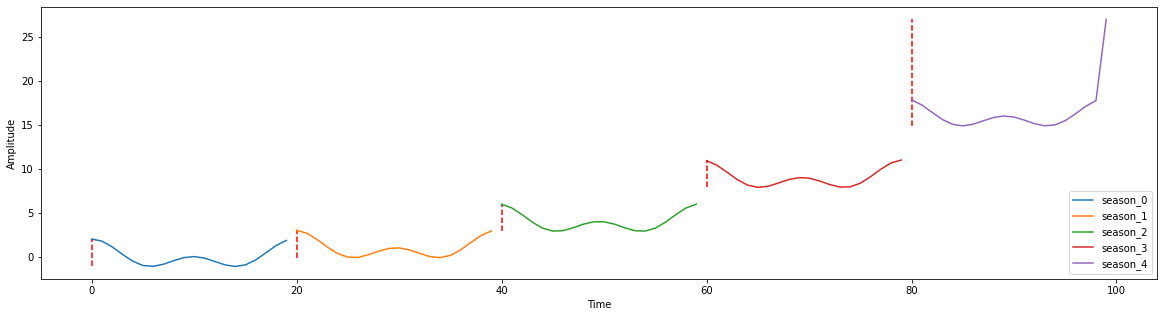

In [399]:
def plot_data(df, title=None):
    plt.figure(figsize= (20,5)) 
    for i, cols in enumerate(df.columns[1:]):
        plt.plot([i*season_length + j for j in range(df.shape[0])], df[cols].values,label=cols)
        plt.vlines(i*season_length, df[cols].min(), df[cols].max(), color='r', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend(loc = 4)
    plt.title(title)
    return plt

plot_data(seasons_df)

### Remove Linear Trends in seasonal cycles

In [558]:
residuals_df = {}

models_dict = {}

for cols in seasons_df.columns[1:]:
    y, X = dmatrices(f'{cols} ~ index', data=seasons_df, return_type='dataframe')
    model = sm.OLS(y, X)       # Set up the model
    result = model.fit()       # Fit model (find the intercept and slopes)
    models_dict[cols] = result
    residuals_df[cols] = result.resid # Residuals
    # print(result.params)

residuals_df = pd.DataFrame(residuals_df)
residuals_df.reset_index(inplace=True)

residuals_df.head()

,index,season_0,season_1,season_2,season_3,season_4
0,0,1.753296,1.855812,1.939700,2.004224,2.820337
1,1,1.532523,1.529975,1.513276,1.482999,2.082751
2,2,0.903257,0.829569,0.751113,0.669181,1.099372
3,3,0.077940,-0.014962,-0.101852,-0.181528,0.132791
4,4,-0.677920,-0.739194,-0.786248,-0.818677,-0.579177


In [559]:
models_dict

{'season_0': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff2c13a6070>,
 'season_1': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff2e2dbae80>,
 'season_2': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff2c19056d0>,
 'season_3': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff2e2702cd0>,
 'season_4': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff2c2484670>}

In [560]:
residual_wave_data = []
for season_i in residuals_df.columns[1:]:
    residual_wave_data.extend(residuals_df[['index',season_i]].values.tolist())
residual_wave_data = pd.DataFrame(residual_wave_data, columns=['index','wave'])
residual_wave_data.tail()

,index,wave
95,15.0,-1.835063
96,16.0,-1.207774
97,17.0,-0.511029
98,18.0,-0.010334
99,19.0,9.081868


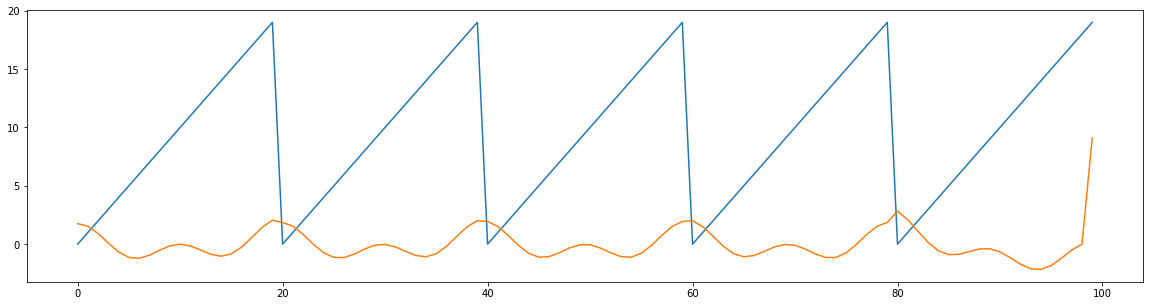

In [403]:
plt.figure(figsize= (20,5))
plt.plot(residual_wave_data)

### Regression

,index,season_0,season_1,season_2,season_3,season_4
0,0,1.753296,1.855812,1.939700,2.004224,2.820337
1,1,1.532523,1.529975,1.513276,1.482999,2.082751
2,2,0.903257,0.829569,0.751113,0.669181,1.099372
3,3,0.077940,-0.014962,-0.101852,-0.181528,0.132791
4,4,-0.677920,-0.739194,-0.786248,-0.818677,-0.579177


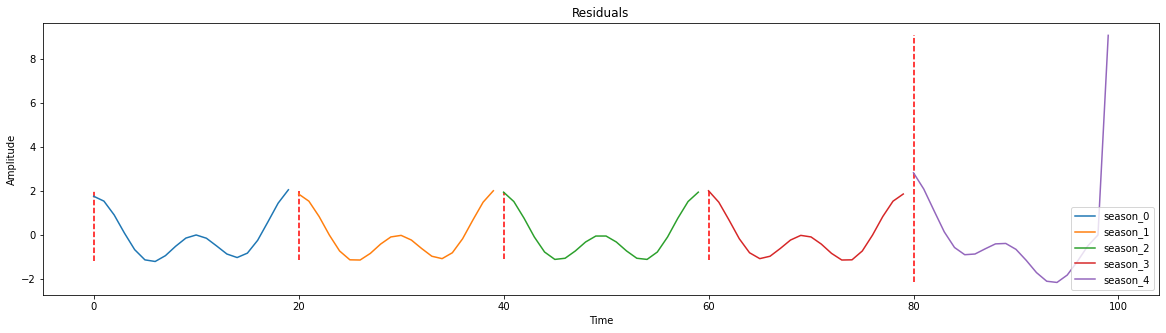

In [568]:
plot_data(residuals_df, title = "Residuals")
residuals_df.head()

In [570]:
# from patsy import dmatrices

# formula = 'index ~ 0+ {}'.format('+'.join(seasons_df.columns[1:]))
# print(formula)
# X, y = dmatrices(formula, data=residuals_df)#, return_type='dataframe')
# # plt.scatter(X,y)
# X[-5:], y[-5:]

# .

In [631]:
class FourierRegression:
    
    def __init__(self, learning_rate, regularization, n_epoch, sampling_frequency):
        self.learning_rate = learning_rate
        self.n_epoch = n_epoch
        self.regularization = regularization
        self.eps = 10**-8
        
        self.coef = np.zeros((1)) # coefficient vector
        self.cache = np.zeros(self.coef.shape) # used only for rmsprop
        self.prev_update = np.zeros(self.coef.shape[0]) # used only for sgd_momentum
        self.sampling_frequency = sampling_frequency
        self.gama = 0.9 # used only for rmsprop
        self.mu = 0.9 # used in momentum
        return

    def __pre_process(self, X, y):
        X = np.array(X)
        y = np.array(y)
        # print(X.shape, y.shape, y[:,0].shape)

        _ = get_frequencencies(y[:,0], self.sampling_frequency)
        print(_)

        self.omega = np.reshape(2*np.pi*_.index.values , (1,len(_.index))) # omega vector
        self.coef = np.reshape(_.Amplitude.values , (1,len(_.index))) # omega vector
        
        # print(self.omega.shape, self.coef.shape)

        self.cache = np.zeros(self.coef.shape) # used only for rmsprop
        self.prev_update = np.zeros(self.coef.shape[0]) # used only for sgd_momentum
        
        residual_wave_data = []
        for season_i in range(y.shape[1]):
            residual_wave_data.extend(list(zip(X, y[:,season_i])))
        residual_wave_data = np.array(residual_wave_data)
        X, y = np.reshape(residual_wave_data[:,0] , (residual_wave_data.shape[0], 1)), np.reshape(residual_wave_data[:,1] , (residual_wave_data.shape[0], 1))

        X = self.get_features(X)
        # print(residual_wave_data.shape, X.shape, y.shape)
        return X, y

    def rmsprop(self, gradient):
        '''
        updates self.coef based on gradient using rmsprop
        '''
        self.cache = (self.gama*self.cache) + ((1-self.gama)*(gradient**2))
        
        decay = self.cache + self.eps
        learning_coef = (self.learning_rate/np.sqrt(decay))
        
        # Simple SGD implementation
        self.coef -= np.multiply(learning_coef,gradient)
        
        # regularizing all except the w0 term
        self.coef[1:] -= (self.regularization*(self.coef[1:]**2))*(self.learning_rate)
        return
    
    def sgd_momentum(self, gradient):
        '''
        updates self.coef based on gradient using Sgd_momentum
        '''
        # Simple SGD implementation
        update = gradient*self.learning_rate + self.mu*self.prev_update
        self.coef -= update
        self.prev_update = update
        
        # regularizing all except the w0 term
        self.coef[1:] -= (self.regularization*(self.coef[1:]**2))*(self.learning_rate)
        return
    
    def fit(self, X, y, update_rule='sgd_momentum', plot=False):
        '''
        Fit the model given X, y. It uses the specified update_rule
        and displays a plot of the coefficients vs epochs, and mse vs epochs if plot is set as True. 
        
        -> use get_features to get the features from X
        -> for epoch in epochs:
            iterate through all x, y.
                compute prediction using linearPredict.
                compute gradient.
                pass this gradient to the corresponding update function and update the coefficients
                keep track of mse and coefficients
        -> plot if required
        
        '''
        X, y = self.__pre_process(X, y)        
        # return
        
        mse = np.zeros(self.n_epoch)
        coefficients = np.array([np.zeros(self.coef.shape[0])]*self.n_epoch)
        
        # # X = self.get_features(X = X)


        # for epoch in range(0,self.n_epoch):
        #     if update_rule == 'bgd':
        #         print(list(zip(y[0] - self.linearPredict(X[0]), self.coef)))
        #         hypothesis = self.linearPredict(X) # Predicted Y
        #         error = hypothesis - y
        #         grad = X.T@error # Gradient
        #         self.coef -= grad # Update coefficients 
        #     elif update_rule in {'sgd_momentum','RMSprop'}:
        #         for i in range(X.shape[0]):
        #             # Compute error
        #             hypothesis = self.linearPredict(X[i]) # Predicted Y
        #             error = hypothesis - y[i]
        #             # print(hypothesis, y[i], error)
        #             # Compute gradients
        #             grad = error*X[i] # Gradient
        #             # print(self.coef)
        #             # Update weights
        #             if update_rule == "sgd_momentum":
        #                 self.sgd_momentum(gradient= grad)
        #             elif update_rule == "RMSprop":
        #                 self.rmsprop(gradient= grad)
        #     else:
        #         raise Exception("Update Rule {rule} is invalid. Please choose either 'bgd', 'sgd_momentum', 'RMSprop'")
        
        #     # print(self.coef)
        #     coefficients[epoch] = np.resize(self.coef.copy(), (1,self.coef.shape[0]))
        #     residuals = y - self.linearPredict(X)         
        #     mse[epoch] = np.mean(residuals**2)
        
        # print(coefficients)
        
        if plot:
            fig, ax = plt.subplots(1,2, sharex= True, sharey=False)
            fig.set_size_inches(30, 10,  forward=True)
            
            ax[1].plot(range(1,self.n_epoch+1),mse)
            ax[1].set_xlabel('epoch', fontsize = "16")
            ax[1].set_ylabel('MSE', fontsize = "16")
            
            # print(self.coef, self.omega)
            for index in range(self.coef.shape[0]):
                ax[0].plot(range(1,self.n_epoch+1), coefficients[:,index], label=f'w {str(np.round(self.omega[0][index], 4))}')
            ax[0].legend()
            ax[0].set_xlabel('epoch', fontsize = "16")
            ax[0].set_ylabel('parameter value', fontsize = "16")
            
            plt.suptitle("{method} ;Learning Rate: {learn}; Regularisation: {reg}".format(method = update_rule, learn = self.learning_rate, reg = self.regularization), fontsize = 25)
            plt.show()
        
        # print(mse)
        # print(self.coef)
        return mse[-1]

    def get_features(self, X):
        # print(X)
        return np.cos(X@self.omega)
        
    def linearPredict(self, X_features):
        '''
        returns the dot product of X and self.coef
        '''
        if len(X_features.shape) == 1:
            X_features = np.reshape(np.array(X_features), (1, X_features.shape[0]))
        return (X_features @ self.coef.T)/2
       # Scaling factor needed to make the wave have the same amplitude as the original wave

    def predict(self, X):
        '''
        Predict the output of the model given X.
        '''
        X = self.get_features(X = X)
        # print(X)
        return self.linearPredict(X)

In [632]:
# n = 100 # number of coefficients
fourierModel = FourierRegression(n_epoch = 1, learning_rate = 0.1, regularization = 0.1, sampling_frequency = 10)

fourierModel.fit(X=residuals_df['index'], y= residuals_df.iloc[:,1:], plot=False)
fourierModel.coef

2.0
           Amplitude     Phase      Real  Imaginary                wave
Frequency                                                              
 0.5        1.143841  0.180062  2.250697   0.409703  2.250697+0.409703j
 1.0        1.096508  0.139321  2.171766   0.304546  2.171766+0.304546j
-1.0        1.096508 -0.139321  2.171766  -0.304546  2.171766-0.304546j
-0.5        1.143841 -0.180062  2.250697  -0.409703  2.250697-0.409703j


array([[1.14384124, 1.09650767, 1.09650767, 1.14384124]])

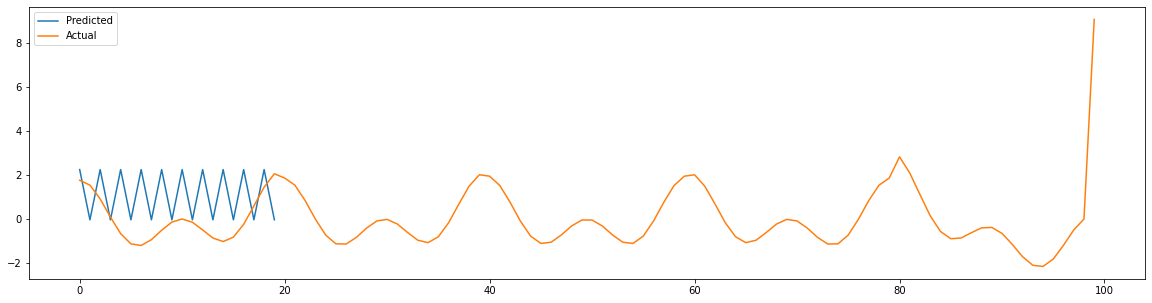

In [633]:
plt.figure(figsize=(20,5))
plt.plot(fourierModel.predict(y), label="Predicted")
plt.plot(residual_wave_data['wave'], label="Actual")
plt.legend()

In [ ]:
# %matplotlib inline
# import random
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd


# num_of_coefs = 6

# class LinearRegression:
    
#     def __init__(self, learning_rate, regularization, n_epoch):
#         self.learning_rate = learning_rate
#         self.n_epoch = n_epoch
#         self.regularization = regularization
#         self.eps = 10**-8
#         self.coef = np.zeros(num_of_coefs) # coefficient vector
#         self.prev_update = np.zeros(num_of_coefs)
#         self.cache = np.zeros(self.coef.shape) # used only for rmsprop
#         self.gama = 0.9 # used only for rmsprop
#         self.mu = 0.9 # used in momentum
#         return

#     def rmsprop(self, gradient):
#         '''
#         updates self.coef based on gradient using rmsprop
#         '''
#         self.cache = (self.gama*self.cache) + ((1-self.gama)*(gradient**2))
        
#         decay = self.cache + self.eps
#         learning_coef = (self.learning_rate/np.sqrt(decay))
        
#         # Simple SGD implementation
#         self.coef -= np.multiply(learning_coef,gradient)
        
#         # regularizing all except the w0 term
#         self.coef[1:] -= (self.regularization*(self.coef[1:]**2))*(self.learning_rate)
#         return
    
#     def sgd_momentum(self, gradient):
#         '''
#         updates self.coef based on gradient using Sgd_momentum
#         '''
#         # Simple SGD implementation
#         update = (gradient*self.learning_rate + self.mu*self.prev_update)
#         self.coef -= update
#         self.prev_update = update
        
#         # regularizing all except the w0 term
#         self.coef[1:] -= (self.regularization*(self.coef[1:]**2))*(self.learning_rate)

#         return
    
#     def fit(self, X, y, update_rule='sgd_momentum', plot=False):
#         '''
#         Fit the model given X, y. It uses the specified update_rule
#         and displays a plot of the coefficients vs epochs, and mse vs epochs if plot is set as True. 
        
#         -> use get_features to get the features from X
#         -> for epoch in epochs:
#             iterate through all x, y.
#                 compute prediction using linearPredict.
#                 compute gradient.
#                 pass this gradient to the corresponding update function and update the coefficients
#                 keep track of mse and coefficients
#         -> plot if required
        
#         '''
#         mse = np.zeros(self.n_epoch)
#         coefficients = np.array([np.zeros(self.coef.shape[0])]*self.n_epoch)
        
#         X = self.get_features(X = X)

#         grad = np.zeros(self.coef.shape[0])

#         for epoch in range(0,self.n_epoch):
            
#             for i in range(X.shape[0]):
#                 # Compute error
#                 hypothesis = self.linearPredict(X[i]) # Predicted Y
#                 error = hypothesis - y[i]
#                 # Compute gradients
#                 grad = error*X[i]
#                 # Update weights
#                 if update_rule == "sgd_momentum":
#                     self.sgd_momentum(gradient= grad)
#                 elif update_rule == "RMSprop":
#                     self.rmsprop(gradient= grad)
#                 else:
#                     raise Exception("Update Rule {rule} is invalid. Please choose either 'bgd', 'sgd_momentum', 'RMSprop'")
        
#             coefficients[epoch] = self.coef.copy()
#             residuals = y - self.linearPredict(X)         
#             mse[epoch] = np.mean(residuals**2)
        
#         if plot:
#             fig, ax = plt.subplots(1,2, sharex= True, sharey=False)
#             fig.set_size_inches(30, 10,  forward=True)
            
#             ax[1].plot(range(1,self.n_epoch+1),mse)
#             ax[1].set_xlabel('epoch', fontsize = "16")
#             ax[1].set_ylabel('MSE', fontsize = "16")
            
#             ax[0].plot(range(1,self.n_epoch+1),coefficients[:,0],label='w0')
#             ax[0].plot(range(1,self.n_epoch+1),coefficients[:,1],label='w1')
#             ax[0].plot(range(1,self.n_epoch+1),coefficients[:,2],label='w2')
#             ax[0].plot(range(1,self.n_epoch+1),coefficients[:,3],label='w3')
#             ax[0].plot(range(1,self.n_epoch+1),coefficients[:,4],label='w4')
#             ax[0].plot(range(1,self.n_epoch+1),coefficients[:,5],label='w5')
#             ax[0].legend()
#             ax[0].set_xlabel('epoch', fontsize = "16")
#             ax[0].set_ylabel('parameter value', fontsize = "16")
            
#             plt.suptitle("{method} ;Learning Rate: {learn}; Regularisation: {reg}".format(method = update_rule, learn = self.learning_rate, reg = self.regularization), fontsize = 25)

#             plt.show()
#         return mse[-1]

#     def get_features(self, X):
#        x = np.zeros((X.shape[0], self.coef.shape[0]))
#        x[:,0] = 1
#        x[:,1] = X[:,0]
#     #    x[:,2] = X[:,0]*X[:,1]
#     #    x[:,3] = (X[:,0]**2)*X[:,1]
#     #    x[:,4] = X[:,0] * (X[:,1]**2)
#     #    x[:,5] = X[:,1]**3
       
#        return x
        
#     def linearPredict(self, X_features):
#        '''
#        returns the dot product of X and self.coef
#        '''
#        omega = np.reshape(2*np.pi*magnitudes.index,(magnitudes.shape[0],1))
#        time = np.reshape(time,(1, time.shape[0]))
#        return (np.cos((omega @ time)).T @ magnitudes)/2

#     def reconstruct_wave(magnitudes, time):
#         omega = np.reshape(2*np.pi*magnitudes.index,(magnitudes.shape[0],1))
#         time = np.reshape(time,(1, time.shape[0]))
#         return (np.cos((omega @ time)).T @ magnitudes)/2#*np.pi#*(n**0.1)) 
#         # Scaling factor needed to make the wave have the same amplitude as the original wave